In [1]:
# from openai import OpenAI

# client = OpenAI(
#     base_url="https://lzl4i1wx0cdh9a-8000.proxy.runpod.net/v1",
#     api_key=""
# )

# resp = client.chat.completions.create(
#     model="llama4scout",
#     messages=[
#         {"role": "system", "content": "You are a concise assistant."},
#         {"role": "user", "content": "Привет! Что такое LLM? Кратко."}
#     ],
#     temperature=0.2,
# )
# print(resp.choices[0].message.content)

In [2]:
from IPython.display import Image, display

import app.agent as agent

In [3]:
graph = agent.build_agent_with_router()

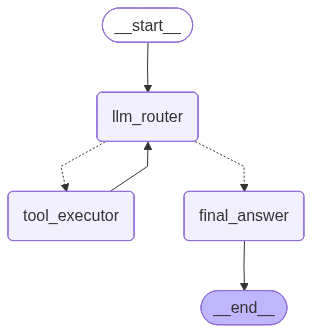

In [3]:
# display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
from app.agent import AgentState
from langchain_core.messages import (
    HumanMessage,
)

In [5]:
# user_q = "топ-5 продуктов (наименования) по продажам в тенге за последние 30 дней"

# init_state: AgentState = {
#     "messages": [HumanMessage(user_q)],
#     "next_tool": None,
#     "tool_args": None,
#     "final_answer_ready": False,
# }

config = {"configurable": {"thread_id": "user_123"}}
msg = {"messages": [{"role": "user", "content": "топ-5 продуктов (наименования) по продажам в тенге за последние 30 дней"}]}

out = graph.invoke(msg, config=config)

 - TOOL CALL: execute_query(SELECT product_name, SUM(sales_amount_tg) as total_sales FROM fact_sales WHERE order_date >= date('now', '-30 days') GROUP BY product_name ORDER BY total_sales DESC LIMIT 5)
 - TOOL CALL: list_tables()
 - TOOL CALL: describe_table(fact_sales)
 - TOOL CALL: describe_table(dict_sku)
 - TOOL CALL: execute_query(SELECT T2.sku_name, SUM(T1.sales_tg) as total_sales FROM fact_sales T1 JOIN dict_sku T2 ON T1.sku_id = T2.sku_id WHERE T1.order_date >= date('now', '-30 days') GROUP BY T2.sku_name ORDER BY total_sales DESC LIMIT 5)


In [6]:
print(out['messages'][-1].content)

Топ-5 продуктов по продажам в тенге за последние 30 дней:
1. НАПИТОК COCA COLA 1Л П/Б - 11 717 825,00 ₸
2. Сахар белый песок (вес) - 11 690 356,24 ₸
3. БАТОНЧИК ШОКОЛАДНЫЙ SNICKERS SUPER 80ГР ФЛ/П - 3 604 315,00 ₸
4. ТОМАТЫ КАЗАХСТАН КГ - 3 364 439,87 ₸
5. БАТОНЧИК SNICKERS СУПЕРПИТАТЕЛЬНЫЙ 50,5ГР СТИК - 2 966 990,00 ₸


In [7]:
config = {"configurable": {"thread_id": "user_123"}}
msg = {"messages": [{"role": "user", "content": "Дай график"}]}

out = graph.invoke(msg, config=config)

 - TOOL CALL: make_simple_plot(b6f234963d2ea47e, sku_name, total_sales, Топ-5 продуктов по продажам в тенге за последние 30 дней, bar, None)


In [8]:
print(out['messages'][-1].content)

Топ-5 продуктов по продажам в тенге за последние 30 дней:

1. НАПИТОК COCA COLA 1Л П/Б - 11 717 825,00 ₸
2. Сахар белый песок (вес) - 11 690 356,24 ₸
3. БАТОНЧИК ШОКОЛАДНЫЙ SNICKERS SUPER 80ГР ФЛ/П - 3 604 315,00 ₸
4. ТОМАТЫ КАЗАХСТАН КГ - 3 364 439,87 ₸
5. БАТОНЧИК SNICKERS СУПЕРПИТАТЕЛЬНЫЙ 50,5ГР СТИК - 2 966 990,00 ₸

Изображение графика: /Users/aziz/Documents/repos/shai-hackathon/data/plots/bar_plot_sku_name_total_sales.png
